<a href="https://colab.research.google.com/github/lci0502/deep-learning-from-scratch/blob/master/3d_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!ls

drive  sample_data


In [0]:
import os
os.chdir('drive/My Drive/deep_learning')

In [5]:
!pip install tensorflow==2.0.0-rc1

     |████████████████████████████████| 86.3MB 46kB/s 
     |████████████████████████████████| 501kB 43.0MB/s 
     |████████████████████████████████| 4.3MB 45.4MB/s 
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [6]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [10]:
!git clone https://github.com/pydicom/pydicom.git

Cloning into 'pydicom'...
remote: Enumerating objects: 2139, done.
remote: Counting objects: 100% (2139/2139), done.
remote: Compressing objects: 100% (795/795), done.
remote: Total 36823 (delta 1913), reused 1464 (delta 1331), pack-reused 34684
Receiving objects: 100% (36823/36823), 59.13 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (29661/29661), done.
Checking out files: 100% (425/425), done.


In [11]:
!git clone https://github.com/hiram64/3D-VoxelDataGenerator.git

Cloning into '3D-VoxelDataGenerator'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [12]:
!git pull

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [0]:
!ls -ltr

total 453
-rw-------  1 root root  15852 Apr 23 01:29  launch.ipynb
drwx------ 10 root root   4096 Apr 23 02:37  pydicom
drwx------  4 root root   4096 Apr 23 02:37  3D-VoxelDataGenerator
-rw-------  1 root root 438823 Apr 23 05:21 '3d data augmentation.ipynb'


In [0]:
!pip install -q VoxelDataGenerator

ERROR: Could not find a version that satisfies the requirement VoxelDataGenerator (from versions: none)
ERROR: No matching distribution found for VoxelDataGenerator


In [0]:
!pip install -q keras

In [0]:
import matplotlib.pyplot as plt
import io
import pydicom
import tensorflow as tf
import os
import numpy as np
import math
import random
from scipy.ndimage.interpolation import shift, zoom
from scipy.ndimage import rotate
from numpy import expand_dims
from glob import glob
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from io import StringIO
from matplotlib import cm
from operator import itemgetter
from voxel_data_generator import VoxelDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential 
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Conv3D
from keras.layers import MaxPooling2D, MaxPool3D, MaxPooling3D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout, Input, BatchNormalization
from skimage.transform import resize

ModuleNotFoundError: ignored

In [0]:
# 데이터 불러오기

In [0]:
# 데이터 경로
PathDicom = "C:/Users/codls/Desktop/dcm/1/"

# 데이터들 빈 list에 저장
lstFilesDCM = []  
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".ima" in filename.lower():  # 폴더에 .ima 파일이 있으면 리스트에 추가
            lstFilesDCM.append(os.path.join(dirName,filename))

In [0]:
print(lstFilesDCM[0]) # 확인

C:/Users/codls/Desktop/dcm/1/PIG_HIFU.MR.DGMIF_BBB.0004.0001.2019.12.19.12.25.49.826651.75831409.IMA


In [0]:
# Dicom file display

In [0]:
## (1)
# 첫번째 .ima 파일을 읽음
RefDs = pydicom.read_file(lstFilesDCM[0])
    
# Z축을 따라 행, 열, 슬라이스 수 계산
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# 간격 저장 (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
    
# x,y,z 좌표 저장    
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])    
    
# ConstPixelDims에 맞게 array 크기를 맞춰줌
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
  
# 모든 다이콤 파일 루프    
for filenameDCM in lstFilesDCM:
    # 파일 읽기
    ds = pydicom.read_file(filenameDCM)
    # 데이터 저장
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

In [0]:
ArrayDicom.shape

(256, 256, 192)

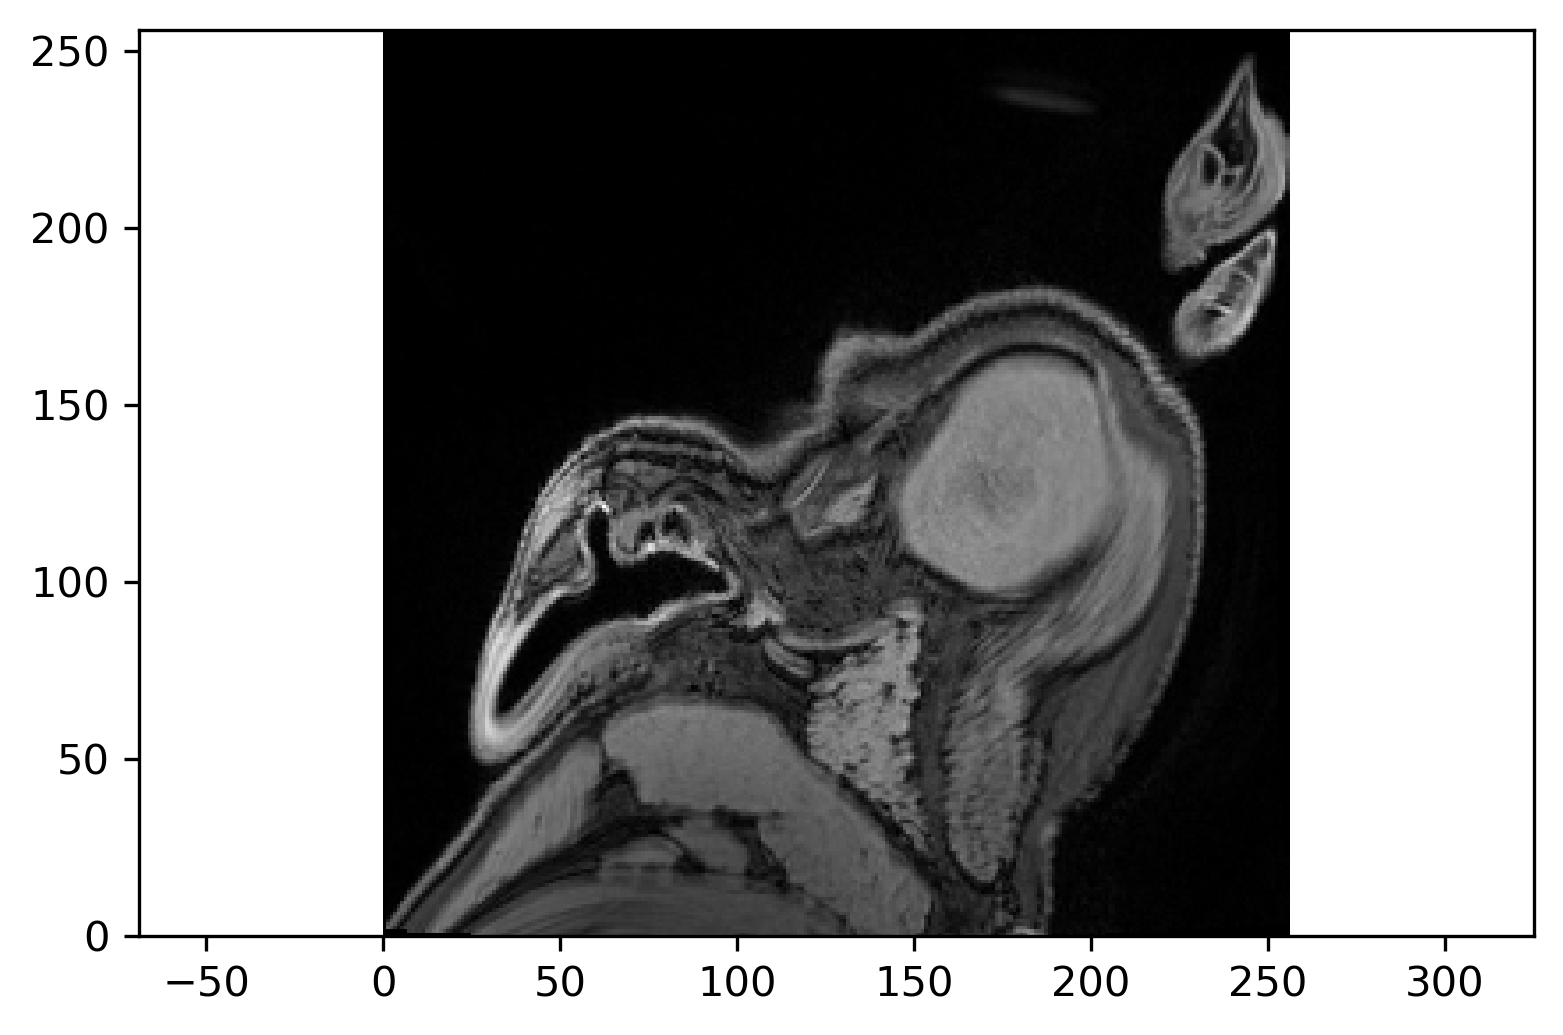

In [0]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
# flipud > array 배열 뒤집기
plt.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 26])) # z축 조절할 수 있음

In [0]:
## (2)
ConstPixelDims = (len(lstFilesDCM),int(RefDs.Rows), int(RefDs.Columns))

In [0]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom1 = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
print(ArrayDicom1.shape)
# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # 파일 읽기
    ds = pydicom.read_file(filenameDCM)
    # array 형태로 저장
    ArrayDicom1[lstFilesDCM.index(filenameDCM), :, :] = ds.pixel_array  

(192, 256, 256)


In [0]:
# 10번째 slice display
plt.imshow(ArrayDicom1[9,:,:])

In [0]:
# 3D augmentation

In [0]:
## >> ima→array한 파일을 display

In [0]:
## ArrayDicom 이 3D 데이터 1 set

In [0]:
## VoxelDataGenerator 

In [0]:
# z축 범위(0~9) 설정, 처리 속도 위해
data1 = ArrayDicom[:, :, :10]

In [0]:
# VoxelDataGenerator 사용 시 batch가 요구됨, batch 추가
samples= data1.reshape((1,)+data1.shape)
#samples = data
#samples.shape

In [0]:
print(samples.shape)

(1, 256, 256, 10)


In [0]:
# test.py의 c, ImageDataGenerator 함수, generator
train_datagen = VoxelDataGenerator(flip_axis=None,
                      shift_axis='random', shift_range='random',
                      zoom_axis='random', zoom_range='random',
                      rotate_axis=3, rotate_angle='random')

In [0]:
# 나중 딥러닝 때 test에 사용하는 것, 지금 x
test_datagen = VoxelDataGenerator(flip_axis=None,
                      shift_axis=None, shift_range=0,
                      zoom_axis='same', zoom_range=0,
                      rotate_axis=None, rotate_angle=0)

In [0]:
# generator를 data에 적용
training_set = train_datagen.build(data=samples, batch_size = 1)

In [0]:
# 나중 딥러닝 때 사용하는 것
test_set = test_datagen.build(data=samples, batch_size = 1)

In [0]:
print(type(train_datagen)) # 모듈
print(type(training_set)) # generator

<class 'voxel_data_generator.VoxelDataGenerator'>
<class 'generator'>


In [0]:
type(next(training_set)[0])

numpy.ndarray

In [0]:
print(next(training_set)[0].shape)

(256, 256, 10)


In [0]:
## generator voxel plot

Text(0.5, 0, 'z')

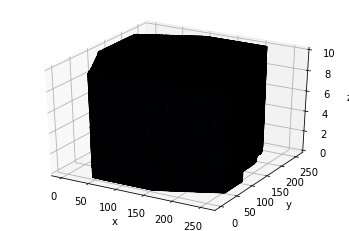

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.voxels(next(training_set)[0], edgecolor='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [0]:
## generator data 1 slice

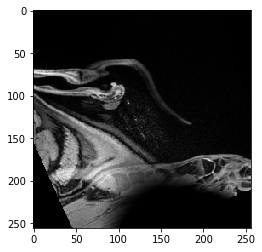

In [0]:
plt.imshow(next(training_set)[0,:,:,0])

In [0]:
## original voxel plot

Text(0.5, 0, 'z')

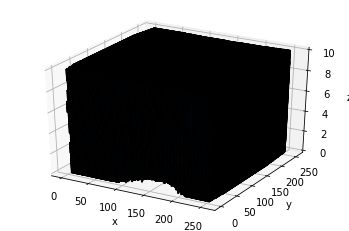

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.voxels(data1, edgecolor='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [0]:
data1.shape

In [0]:
##original data 1 slice

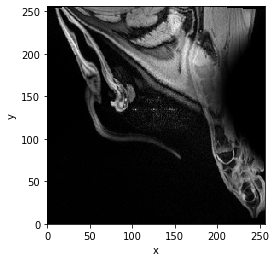

In [0]:
plt.imshow(data1[:,:,0])
plt.xlabel('x');
plt.ylabel('y');
plt.xlim(0,256);
plt.ylim(0,256);

In [0]:
samples.shape

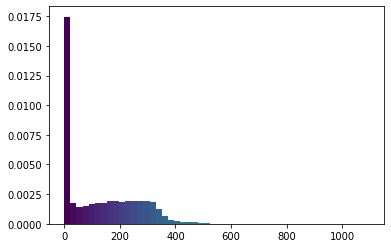

In [0]:
## normalization
def normalize(ArrayDicom):
    ArrayDicom_min = np.min(ArrayDicom)
    return (ArrayDicom-ArrayDicom_min)/(np.max(ArrayDicom)-ArrayDicom_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()

show_histogram(ArrayDicom)

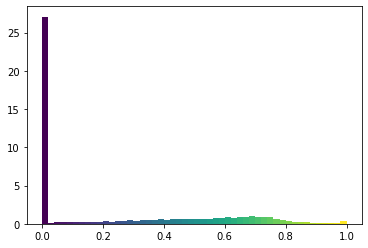

In [0]:
## 
def scale_by(ArrayDicom, fac):
    mean = np.mean(ArrayDicom)
    return (ArrayDicom-mean)*fac + mean

transformed = np.clip(scale_by(np.clip(normalize(ArrayDicom)-0.1, 0, 1)**0.4, 2)-0.1, 0, 1)
show_histogram(transformed)

In [0]:
ArrayDicom.shape

(256, 256, 192)

In [0]:
data=ArrayDicom

In [0]:
##
resized = resize(ArrayDicom, (256, 256, 192), mode='constant')

In [0]:
##
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

In [0]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros((shape_arr), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

In [0]:
##
def plot_cube(cube, angle=320):
    cube = normalize(cube)

    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x1, y1, z1 = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)

    ax.voxels(x1, y1, z1, filled, facecolors=facecolors)
    plt.show()

In [0]:
plot_cube(resized[:,:,:])

ValueError: could not broadcast input array from shape (128,128,96,4) into shape (64,64,48,4)

In [0]:
print(training_set)

<generator object VoxelDataGenerator._return_generator at 0x0000020044F66F48>


In [0]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=samples.shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))